In [1]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from io import StringIO
import re
from datetime import date
#from selenium import webdriver
#from selenium.webdriver.chrome.options import Options
from io import BytesIO
from zipfile import ZipFile
import os
from datetime import datetime, timedelta
from yahooquery import Ticker
import time
import random
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from itertools import product

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

warnings.filterwarnings("ignore")

# 国债跨期陡峭／平坦套利策略  
## Treasury Futures Calendar Spread: Steepener & Flattener  

> **策略概述 / Strategy Overview**  
> 利用不同到期月份的国债期货价差随着收益率曲线的陡峭或平坦化（steepening/flattening）而变化的特性，做“多近空远”或“空近多远”跨期套利。  
> Exploit the changes in calendar spread of treasury futures when the yield curve steepens or flattens: go long the near-month and short the far-month (steepener) or vice versa (flattener).

---

## 一、原理 / Rationale  
1. **收益率曲线陡峭化（Steepening）**  
   - 近月收益率上升幅度 < 远月收益率 → 价差缩小 → 做多近月、空远月获利  
   - When long-term yields rise faster than short-term, long the near contract, short the far, capture spread compression.  
2. **收益率曲线平坦化（Flattening）**  
   - 近月收益率下降幅度 < 远月收益率 → 价差扩大 → 做空近月、多远月获利  
   - When short-term yields fall faster than long-term, short the near, long the far, capture spread widening.

---

## 二、信号与入场 / Entry Signals  
- **陡峭信号（Steepener）**  
  1. 监控期货基差：Spread = Price_far − Price_near  
  2. 当 Spread 大于历史均值 + k×σ（偏差放大）时做多 near / 空 far  
- **平坦信号（Flattener）**  
  1. 当 Spread 小于历史均值 − k×σ（偏差缩小）时做空 near / 多 far  


## 策略目标 / Objective  
- 构建一个对利率方向风险中性的跨期头寸，专注赚取“久期差”回归带来的收益  
- Hedge out parallel shifts in the yield curve, profit only from changes in slope (duration spread)

---

1. **获取合约久期 / Get Futures Durations**  
   - 近月合约 Duration₁、远月合约 Duration₂  
   - ΔD = Duration₂ − Duration₁  

2. **计算对冲权重 / Calculate Hedge Weights**  
    $$
   w_{\text{near}} = 1, \quad
   w_{\text{far}} = -\frac{D_{\text{near}}}{D_{\text{far}}}
   $$  
   确保：  
   $$
   w_{\text{near}}\times D_{\text{near}}
   \;+\;
   w_{\text{far}}\times D_{\text{far}}
   \;=\;0
   $$

3. **入场信号 / Entry Signal**  
   - 当 ΔD 偏离历史均值 > k×σ（陡峭） ⇒ 做多近月、等比做空远月  
   - 当 ΔD 偏离均值 < –k×σ（平坦） ⇒ 做空近月、等比做多远月

4. **持仓与平仓 / Hold & Exit**  
   - **平仓**：ΔD 恢复至均值 ± ε，或到固定持有期  
   - **止损**：ΔD 反向突破 ± m×σ 时强制平仓

---

> **要点 / Key Points**  
> - **净久期中性**：两腿按久期配比对冲，零方向风险  
> - **模式**：steepener（陡峭做多近空远）／flattener（平坦做多远空近）  
> - **风控**：限价分批、定期调仓、监控保证金  

*A concise framework for a duration‐neutral treasury futures pairs strategy.*  

In [10]:
import math

def compute_duration_neutral_allocation(principal, duration_short, duration_long, price_short, price_long):
    """
    计算久期中性配置下的 ETF 名义金额和份额
    参数:
      principal (float): 本金（如 100000 日元）
      duration_short (float): 短端久期 (e.g., 4.22)
      duration_long (float): 长端久期 (e.g., 15.50)
      price_short (float): 短端 ETF 收盘价 (e.g., 680)
      price_long (float): 长端 ETF 收盘价 (e.g., 1061)
    返回:
      dict: 包含名义金额和份额 {'notional_short', 'notional_long', 'shares_short', 'shares_long'}
    """
    # 1. 计算名义金额
    notional_short = principal * duration_long / (duration_short + duration_long)
    notional_long = principal - notional_short
    
    # 2. 计算份额（向下取整到整数张）
    shares_short = math.floor(notional_short / price_short)
    shares_long = math.floor(notional_long / price_long)
    
    return {
        'notional_short': notional_short,
        'notional_long': notional_long,
        'shares_short': shares_short,
        'shares_long': shares_long
    }

# 美债
principal = 100000    # 本金（日元）
duration_short = 4.22 # 短端久期
duration_long = 15.50 # 长端久期
price_short = 680     # 2856.T 收盘价
price_long = 1061     # 2621.T 收盘价

result = compute_duration_neutral_allocation(
    principal, duration_short, duration_long, price_short, price_long
)

print("名义金额（短端）：", result['notional_short'])
print("名义金额（长端）：", result['notional_long'])
print("买入份额（短端）2856：", result['shares_short'], "张")
print("卖出份额（长端）2621：", result['shares_long'], "张")


名义金额（短端）： 78600.40567951319
名义金额（长端）： 21399.59432048681
买入份额（短端）2856： 115 张
卖出份额（长端）2621： 20 张


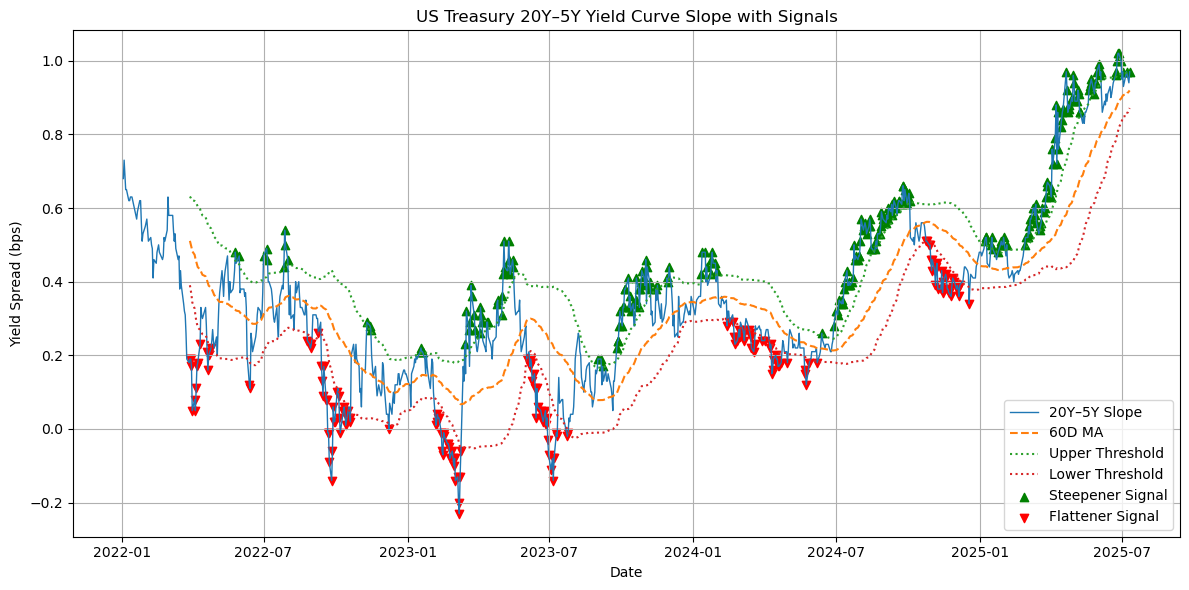

In [11]:
# 年份列表
years = [2025, 2024, 2023, 2022]

# 存储各年数据的列表
dfs = []

for year in years:
    # 构建带年份过滤的 URL
    url = (
        "https://home.treasury.gov/resource-center/data-chart-center/"
        "interest-rates/TextView"
        f"?type=daily_treasury_yield_curve&field_tdr_date_value={year}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table")
    
    # 提取表头
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    # 提取行
    rows = []
    for tr in table.find_all("tr")[1:]:
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        if cells:
            rows.append(cells)
    
    # 转为 DataFrame
    df_year = pd.DataFrame(rows, columns=headers)
    df_year["Date"] = pd.to_datetime(df_year["Date"])
    df_year.set_index("Date", inplace=True)
    
    dfs.append(df_year)

# 合并所有年份的数据
df_all = pd.concat(dfs).sort_index()

# 提取并转换 5Y 和 20Y 列
df = df_all.rename(columns={'5 Yr': 'Y5', '20 Yr': 'Y20'})
df[['Y5', 'Y20']] = df[['Y5', 'Y20']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Y5', 'Y20'])

# 计算 20Y-5Y 利差
df['Slope'] = df['Y20'] - df['Y5']
# 4. 计算滚动统计和信号
window = 60
df['MA'] = df['Slope'].rolling(window).mean()
df['STD'] = df['Slope'].rolling(window).std()
k = 1.0
df['Upper'] = df['MA'] + k * df['STD']
df['Lower'] = df['MA'] - k * df['STD']
df['Signal'] = 0
df.loc[df['Slope'] > df['Upper'], 'Signal'] = 1
df.loc[df['Slope'] < df['Lower'], 'Signal'] = -1

# 5. 可视化并标记信号
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Slope'], label='20Y–5Y Slope', linewidth=1)
plt.plot(df.index, df['MA'], linestyle='--', label='60D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')

# 标记Signal为1的点（Steepener）和Signal为-1的点（Flattener）
steep_dates = df[df['Signal'] == 1].index
flat_dates = df[df['Signal'] == -1].index
plt.scatter(steep_dates, df.loc[steep_dates, 'Slope'], marker='^', color='green', label='Steepener Signal')
plt.scatter(flat_dates, df.loc[flat_dates, 'Slope'], marker='v', color='red', label='Flattener Signal')

plt.title('US Treasury 20Y–5Y Yield Curve Slope with Signals')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 1. 定义ETF代码和各自的久期（年）
tickers = {
    "2856.T": 5.0,   # 3–7年ETF，久期约5年
    "2621.T": 8.0    # 7–10年ETF，久期约8年
}

# 2. 获取历史价格数据
start_date = "2025-01-01"
end_date = "2025-05-20"
data = yf.download(list(tickers.keys()), start=start_date, end=end_date)["Adj Close"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['2856.T', '2621.T']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

# 使用示例
start_date, end_date = '20240501', '20250522'
df = fetch_jgb_yields(start_date, end_date, window=30)

# --- 5. 可视化并标记信号 ---
# —— 假设你已经得到了 df（含 ['Slope','MA','Upper','Lower','Signal']）
# —— 以及 start_date, end_date
today_str = date.today().strftime('%Y%m%d')
start_date, end_date = '20240901', today_str
df = fetch_jgb_yields(start_date, end_date, window=40)
# 标记信号日期
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index

# 创建 Figure
fig = go.Figure()

# 1) 绘制斜率和均线、上下轨
fig.add_trace(go.Scatter(
    x=df.index, y=df['Slope'], mode='lines', name='10Y–5Y Slope'
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['MA'], mode='lines', name='30D MA',
    line=dict(dash='dash')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Upper'], mode='lines', name='Upper Threshold',
    line=dict(dash='dot')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Lower'], mode='lines', name='Lower Threshold',
    line=dict(dash='dot')
))

# 2) 添加 Steepener 信号点
fig.add_trace(go.Scatter(
    x=steep_dates,
    y=df.loc[steep_dates, 'Slope'],
    mode='markers',
    name='Steepener',
    marker_symbol='triangle-up',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 3) 添加 Flattener 信号点
fig.add_trace(go.Scatter(
    x=flat_dates,
    y=df.loc[flat_dates, 'Slope'],
    mode='markers',
    name='Flattener',
    marker_symbol='triangle-down',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 布局调整
fig.update_layout(
    title=f'JGB 10Y-5Y Slope & Signals ({start_date} to {end_date})',
    xaxis_title='Date',
    yaxis_title='Yield Spread (bp)',
    hovermode='closest'
)

# 显示交互式图表
fig.show()

In [14]:
# ust yield
def fetch_ust_yield_spread(start, end, window=30):
    """
    获取美国国债20年-5年期利差，并计算滚动均值、标准差、信号位。
    """

    def load_yearly_yields(year):
        url = (
            "https://home.treasury.gov/resource-center/data-chart-center/"
            "interest-rates/TextView"
            f"?type=daily_treasury_yield_curve&field_tdr_date_value={year}"
        )
        resp = requests.get(url)
        df = pd.read_html(resp.text)[0]
        df = df.rename(columns={"Date": "Date", "5 Yr": "Y5", "20 Yr": "Y20"})
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df = df[['Y5', 'Y20']].astype(float)
        return df

    # 收集目标年份范围内的数据
    year_range = range(pd.to_datetime(start).year, pd.to_datetime(end).year + 1)
    all_data = [load_yearly_yields(year) for year in year_range]
    df_raw = pd.concat(all_data)
    
    # 去重并排序
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]
    df_raw = df_raw.sort_index()

    # 按日期切片
    df_period = df_raw.loc[start:end].copy()
    df_clean  = df_period.dropna()

    # 计算利差指标
    df_clean['Slope'] = df_clean['Y20'] - df_clean['Y5']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1

    return df_clean

In [15]:
#导入函数部分
# --- Module 1: Data Loading ---
def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

def fetch_etf_prices(symbols, start, end):
    """
    从 Stooq 拉取 ETF 收盘价，返回 DataFrame
    """
    def fetch(sym):
        url = f"https://stooq.com/q/d/l/?s={sym}&d1={start}&d2={end}&i=d"
        tmp = pd.read_csv(StringIO(requests.get(url).text),
                          parse_dates=['Date'], index_col='Date')
        return tmp['Close'].sort_index()
    prices = pd.DataFrame({name: fetch(sym) for name, sym in symbols.items()})
    prices.index = prices.index.normalize()
    return prices.loc[start:end].dropna()

# --- Module 2: Strategy & Backtest ---
def run_backtest(signals: pd.DataFrame,
                 prices: pd.DataFrame,
                 durations: dict,
                 position_fn,
                 intraday: bool = False,
                 stop_loss: float = None) -> pd.DataFrame:
    """
    通用回测框架，支持日内/跨日与止损逻辑：
      signals: 包含 ['Slope','MA','Signal']
      prices:  包含 ['Short','Long']
      durations: {'Short':dur_short,'Long':dur_long}
      position_fn: 策略函数(signals,prices)->Series(Position_today)
      intraday: True 时当天 Signal 当天生效；False 则 shift(1)
      stop_loss: 日内最大亏损 (e.g. 0.001 = 0.1%)
    返回含 ['Position','RawReturn','StrategyRet','Cumulative'] 的 DataFrame
    """
    # 1) 计算每日原始组合收益
    rets  = prices.pct_change().dropna()
    hedge = durations['Short'] / durations['Long']
    raw_combo = rets['Short'] - hedge * rets['Long']

    # 2) 生成当天仓位
    df = signals.copy()
    df['Position_today'] = position_fn(signals, prices)
    #日内
    if intraday:
        pos = df['Position_today'].reindex(raw_combo.index).fillna(0).astype(int)
    #跨日
    else:
        pos = df['Position_today'].shift(1).reindex(raw_combo.index).fillna(0).astype(int)

    # 3) 计算策略当天收益，并只对亏损部分止损
    bt = pd.DataFrame({
        'Position':   pos,
        'RawReturn':  raw_combo
    })
    bt['StrategyRet'] = bt['Position'] * bt['RawReturn']
    if stop_loss is not None:
        # 亏损时下限截断到 -stop_loss
        bt['StrategyRet'] = bt['StrategyRet'].clip(lower=-stop_loss)

    # 4) 累计净值
    bt['Cumulative'] = (1 + bt['StrategyRet']).cumprod()
    return bt
# --- Module 3: Visualization ---
def plot_results(bt, output_csv=None):
    """
    在净值曲线上标记 Steepener/Flattener 进入与退出
    """
    df = bt.copy()
    df['PrevPos'] = df['Position'].shift(1).fillna(0)

    # Identify entry and exit points
    entries_steep = df[(df['PrevPos']==0) & (df['Position']==1)]
    entries_flat  = df[(df['PrevPos']==0) & (df['Position']==-1)]
    exits         = df[(df['PrevPos']!=0) & (df['Position']==0)]

    # Calculate total PnL and cumulative return
    total_pnl = df['StrategyRet'].sum()
    cumulative_return_pct = (df['Cumulative'].iloc[-1] - 1) * 100

    # Plot equity curve and markers
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Cumulative'], label='Equity Curve', color='blue')
    plt.scatter(entries_steep.index, entries_steep['Cumulative'],
                marker='^', color='green', s=80, label='Entry Steepener')
    plt.scatter(entries_flat.index, entries_flat['Cumulative'],
                marker='^', color='red', s=80, label='Entry Flattener')
    plt.scatter(exits.index, exits['Cumulative'],
                marker='v', color='gray', s=80, label='Exit')

    # Annotation box at top-right
    plt.text(0.75, 0.95,
             f"Total PnL: {total_pnl:.4f}\n"
             f"Cumulative Return: {cumulative_return_pct:.2f}%",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.title('Strategy Equity with Entry/Exit Points')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Equity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Prepare daily PnL table
    pnl_table = df[['Position', 'StrategyRet']].copy()
    pnl_table['StrategyRet'] = pnl_table['StrategyRet'].round(6)

    # Output or save
    if output_csv:
        pnl_table.to_csv(output_csv, float_format='%.6f')
        print(f"Daily PnL saved to {output_csv}")
    else:
        print("Daily PnL:")
        #print(pnl_table)
        print("cumulative return is:",cumulative_return_pct)

# --- Main Execution ---
if __name__ == "__main__":
    start_date, end_date = '20240501', '20250520'
    # 1. JGB 斜率信号
    #signals = fetch_jgb_yields(start_date, end_date, window=30)
    # 2. ETF 价格
    #symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
    #prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
    #durations = {'Short': 8.2, 'Long': 10.85}
    #bt = run_backtest(signals, prices, durations)
    # 4. 可视化
    #plot_results(bt, output_csv=None)



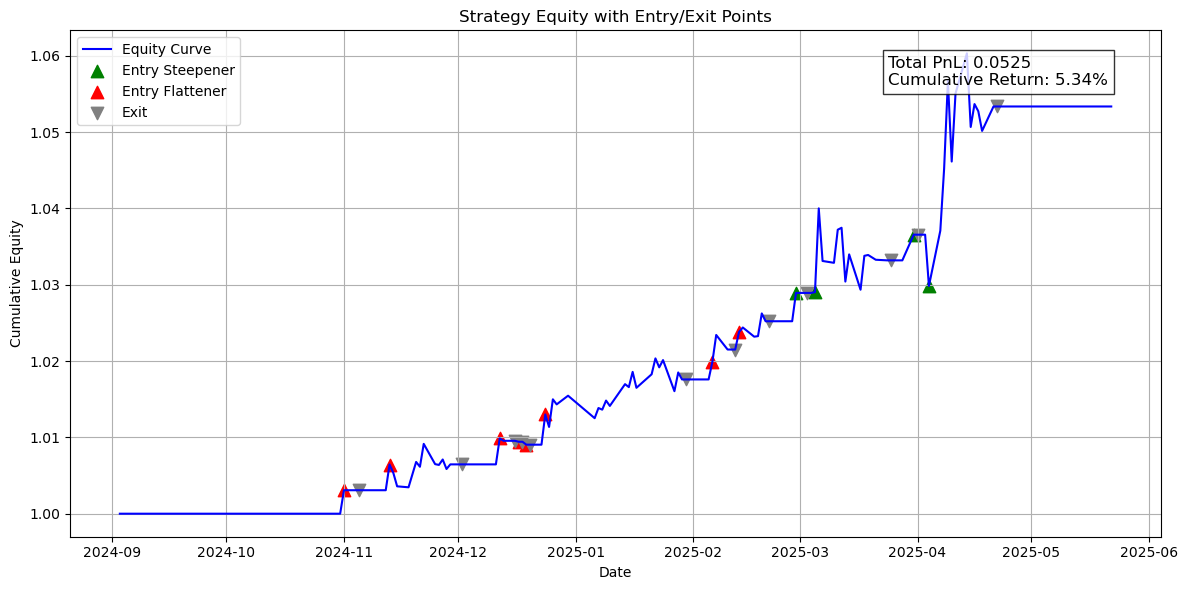

Daily PnL:
cumulative return is: 5.337025729798972


In [16]:
#日内策略 只在跌破止损平仓 jpy
def strat_intraday_signal(signals, prices):
    return signals['Signal'].reindex(prices.index).fillna(0).astype(int)

start_date, end_date = '20240901', '20250522'
signals = fetch_jgb_yields(start_date, end_date, window=40)
# 2. ETF 价格
symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
durations = {'Short': 8.2, 'Long': 10.73}
bt = run_backtest(
    signals, prices, durations,
    position_fn=strat_intraday_signal,
    intraday=True,
    stop_loss=0.01   # 未加百分比 日内止损
)
plot_results(bt)

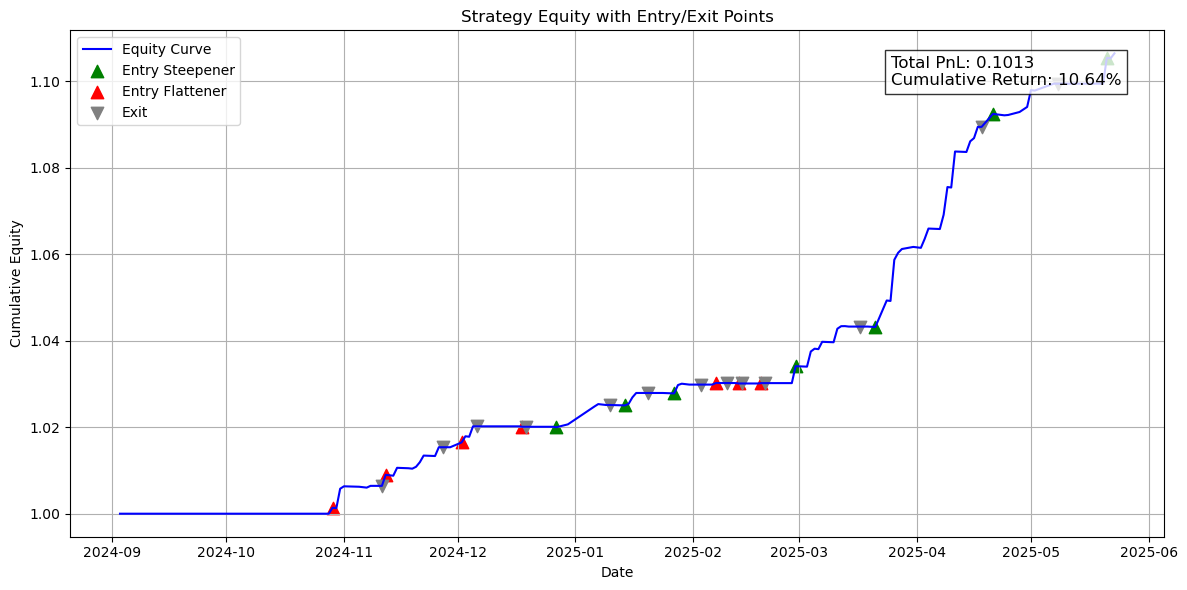

Daily PnL:
cumulative return is: 10.639073588196869


In [17]:
#ust
#日内策略 只在跌破止损平仓
def strat_intraday_signal(signals, prices):
    return signals['Signal'].reindex(prices.index).fillna(0).astype(int)

start_date, end_date = '20240901', '20250523'
signals = fetch_ust_yield_spread(start_date, end_date, window=40)
# 2. ETF 价格
symbols = {'Short':'2856.jp', 'Long':'2621.jp'}
prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
durations = {'Short': 4.22, 'Long': 15.50}
bt = run_backtest(
    signals, prices, durations,
    position_fn=strat_intraday_signal,
    intraday=True,
    stop_loss=0.0001   # 未加百分比 日内止损
)
plot_results(bt)

In [18]:
def strat1_with_stop_debug(signals, prices, durations, stop_loss=0.2):
    pos = 0
    entry_val = 0.0
    hedge = durations['Short']/durations['Long']
    for dt, row in signals.iterrows():
        sig, slope, ma = row['Signal'], row['Slope'], row['MA']
        if dt in prices.index:
            value = prices.at[dt,'Short'] - hedge*prices.at[dt,'Long']
        else:
            continue

        if pos == 0:
            if sig != 0:
                pos = sig
                entry_val = value
                print(f"{dt} 入场，entry_val={entry_val:.6f}")
        else:
            # 判断MA平仓
            if pos==1 and slope <= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            # 判断止损
            elif pos== -1 and slope >= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            elif value < entry_val*(1-stop_loss):
                print(f"{dt} 平仓(止损): value={value:.6f}, 阈值={entry_val*(1-stop_loss):.6f}")
                pos = 0

bt_t = run_backtest(signals, prices, durations,lambda s, p: strat1_with_stop_debug(s, p, durations, stop_loss=0.01))
#plot_results(bt_t)

2024-10-29 00:00:00 入场，entry_val=368.296129
2024-11-01 00:00:00 平仓(止损): value=363.901290, 阈值=364.613168
2024-11-05 00:00:00 入场，entry_val=364.762581
2024-12-05 00:00:00 平仓(止损): value=360.117419, 阈值=361.114955
2024-12-18 00:00:00 入场，entry_val=368.296774
2024-12-20 00:00:00 平仓(斜率回落): slope=0.420000, ma=0.414000
2024-12-27 00:00:00 入场，entry_val=372.142581
2025-02-05 00:00:00 平仓(斜率回落): slope=0.450000, ma=0.460250
2025-02-07 00:00:00 入场，entry_val=368.992258
2025-02-25 00:00:00 平仓(斜率回落): slope=0.470000, ma=0.466000
2025-02-28 00:00:00 入场，entry_val=369.685806


In [19]:
#筛选止损

# --- 1. 基本配置 ---
start, end = '2024-09-01', '2025-05-20'
symbols   = {'Short':'236a.jp', 'Long':'2561.jp'}
durations = {'Short':8.2, 'Long':10.85}

# 拉信号和价格
signals = fetch_jgb_yields(start, end, window=30)
prices  = fetch_etf_prices(symbols, start.replace('-',''), end.replace('-',''))

# --- 2. 参数扫描 ---
results = []
for sl in np.arange(0.005, 0.051, 0.005):
    # 用 strat4，这里需要把 strat4 包装成 position_fn
    position_fn = lambda s,p,sl=sl: strat4(s, p, durations, stop_loss=sl)
    bt = run_backtest(signals, prices, durations, position_fn)

    # 计算指标
    total_ret = bt['Cumulative'].iloc[-1] - 1
    mdd       = max_drawdown(bt['Cumulative'])
    win_rate, pl_ratio = analyze_trades(bt)

    results.append({
        'stop_loss':   sl,
        'total_return':total_ret,
        'max_drawdown':mdd,
        'win_rate':    win_rate,
        'pl_ratio':    pl_ratio
    })

res_df = pd.DataFrame(results)

# --- 3. 输出表格 ---
print("\nStop-loss Scan Results:")
print(res_df.to_string(index=False))

# --- 4. 可视化：Total Return vs Stop-loss Level ---
plt.figure(figsize=(8,4))
plt.plot(res_df['stop_loss'], res_df['total_return'], marker='o', linestyle='-')
for sl, tr in zip(res_df['stop_loss'], res_df['total_return']):
    plt.text(sl, tr, f"{tr:.2%}", ha='center', va='bottom')

best = res_df.loc[res_df['total_return'].idxmax()]
plt.text(0.75, 0.15,
         f"Best SL: {best.stop_loss:.1%}\nTotal Ret: {best.total_return:.2%}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.title('Total Return vs. Stop-loss Level')
plt.xlabel('Stop-loss Level')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'strat4' is not defined

In [ ]:
"""
通过累加 StrategyRet 计算每笔交易的真实收益率：
    entry_date, exit_date, return, win (1=盈利, 0=亏损)
bt: 包含 ['Position','StrategyRet'] 的 DataFrame
"""
def extract_trades(bt: pd.DataFrame) -> pd.DataFrame:
    """
    通过累加 StrategyRet 计算每笔交易的真实收益率：
      entry_date, exit_date, return, win (1=盈利, 0=亏损)
    bt: 包含 ['Position','StrategyRet'] 的 DataFrame
    """
    trades = []
    pos = 0
    entry_date = None

    # 遍历每一天
    for date, row in bt.iterrows():
        # 开仓
        if pos == 0 and row['Position'] != 0:
            pos = row['Position']
            entry_date = date

        # 平仓
        elif pos != 0 and row['Position'] == 0:
            exit_date = date
            # 真实回报 = 这笔交易期间 StrategyRet 的累积乘积减 1
            period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
            ret = period.prod() - 1
            trades.append({
                'entry_date': entry_date,
                'exit_date':  exit_date,
                'return':     ret,
                'win':        int(ret > 0)
            })
            pos = 0
            entry_date = None

    # 期末强制平仓
    if pos != 0 and entry_date is not None:
        exit_date = bt.index[-1]
        period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
        ret = period.prod() - 1
        trades.append({
            'entry_date': entry_date,
            'exit_date':  exit_date,
            'return':     ret,
            'win':        int(ret > 0)
        })

    return pd.DataFrame(trades)

# —— 使用示例 ——  
trade_df = extract_trades(bt)  
print("交易明细：")  
print(trade_df.to_string(index=False))  
win_rate = trade_df['win'].mean()  
print(f"\n重新计算胜率：{win_rate:.2%}")  
# 计算盈亏比（平均盈利 / 平均亏损）  
wins    = trade_df.loc[trade_df['win']==1, 'return']  
losses  = trade_df.loc[trade_df['win']==0, 'return']  
# 如果没有亏损或没有盈利，要做边界处理  
if not wins.empty and not losses.empty:  
    pl_ratio = wins.mean() / -losses.mean()  
elif wins.empty:  
    pl_ratio = 0.0  
else:  
    pl_ratio = float('inf')

print(f"Win Rate:    {win_rate:.2%}")  
print(f"P/L Ratio:   {pl_ratio:.2f}")  

交易明细：
entry_date  exit_date    return  win
2024-11-01 2024-11-05  0.003077    1
2024-11-13 2024-12-02  0.003378    1
2024-12-12 2024-12-16  0.003070    1
2024-12-17 2024-12-18 -0.000126    0
2024-12-19 2024-12-20 -0.000377    0
2024-12-24 2025-01-30  0.008474    1
2025-02-06 2025-02-12  0.003852    1
2025-02-13 2025-02-21  0.003629    1
2025-02-28 2025-03-03  0.003621    1
2025-03-05 2025-03-25  0.004146    1
2025-03-31 2025-04-01  0.003258    1
2025-04-04 2025-04-22  0.016209    1

重新计算胜率：83.33%
Win Rate:    83.33%
P/L Ratio:   20.95
